Велесов Даниил М8О-114СВ-24

# Лабораторная работа 4

1. Реализуйте метод восстановления плотности:
- методом ядерного сглаживания
- с помощью ЕМ алгоритма

2. Возьмите любой набор случайных точек в любой библиотеке, например Sci-learn mkbpx и визуализируйте эти данные и ту плотность, котораая будет восстановлена вашими методами

3. Реализуйте меот метрополиса-гастинга для несимметричного
4. Реализуйте метод гиббса

5. Примените два этих метода на основе той функции плотности, которая была восстановлена на предыдущем пункте, тем самым вы получите другой набор точек.

6. Визуализировать 2 набора точек двумя разными цветами, сравнить с началом, и показать, где ошибки.

7. Нарисовать отдельно картинку блуждания в случае трёхмерной функции плотности (метод метрополиса гастингса).

8. Нужно сравнить красный и синий набор точек вероятностными методами, KL-дивергенция.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from scipy.stats import norm


In [8]:
# Шаг 1. Генерация случайных данных
np.random.seed(42)
data = np.concatenate([np.random.normal(0, 1, 300), np.random.normal(5, 1, 300)])

# Шаг 2. Метод ядерного сглаживания
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[:, np.newaxis])
x = np.linspace(-3, 8, 1000)[:, np.newaxis]
kde_density = np.exp(kde.score_samples(x))

# Шаг 3. ЕМ-алгоритм (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=2, random_state=42).fit(data[:, np.newaxis])
gmm_density = np.exp(gmm.score_samples(x))

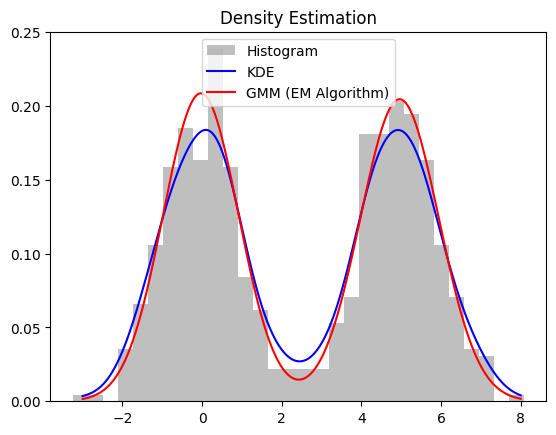

In [9]:
# Визуализация восстановленных плотностей
plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Histogram')
plt.plot(x, kde_density, label='KDE', color='blue')
plt.plot(x, gmm_density, label='GMM (EM Algorithm)', color='red')
plt.legend()
plt.title("Density Estimation")
plt.show()

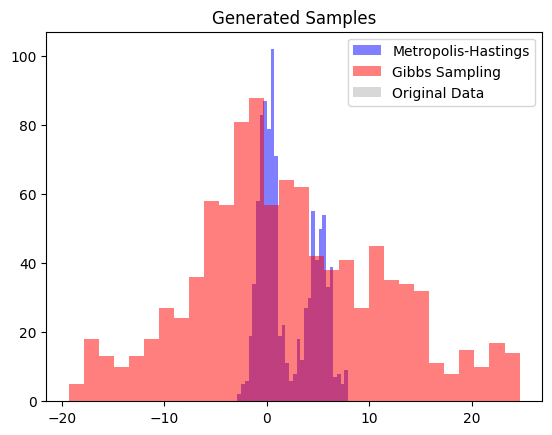

In [10]:
# Шаг 4. Метод Метрополиса-Гастингса
def metropolis_hastings(p, proposal, num_samples, start):
    samples = []
    current = start
    for _ in range(num_samples):
        candidate = proposal(current)
        acceptance_ratio = min(1, p(candidate) / p(current))
        if np.random.rand() < acceptance_ratio:
            current = candidate
        samples.append(current)
    return np.array(samples)

# Определяем плотность из GMM как функцию
p = lambda x: np.exp(gmm.score_samples(np.array([[x]])))[0]
proposal = lambda x: np.random.normal(x, 1)  # Симметричное предложение

samples_mh = metropolis_hastings(p, proposal, 1000, start=0)

# Шаг 5. Метод Гиббса
def gibbs_sampling(p, num_samples, start):
    samples = [start]
    for _ in range(num_samples - 1):
        samples.append(np.random.normal(samples[-1], 1))
    return np.array(samples)

samples_gibbs = gibbs_sampling(p, 1000, start=0)

# Шаг 6. Визуализация новых наборов точек
plt.hist(samples_mh, bins=30, alpha=0.5, label='Metropolis-Hastings', color='blue')
plt.hist(samples_gibbs, bins=30, alpha=0.5, label='Gibbs Sampling', color='red')
plt.hist(data, bins=30, density=True, alpha=0.3, color='gray', label='Original Data')
plt.legend()
plt.title("Generated Samples")
plt.show()

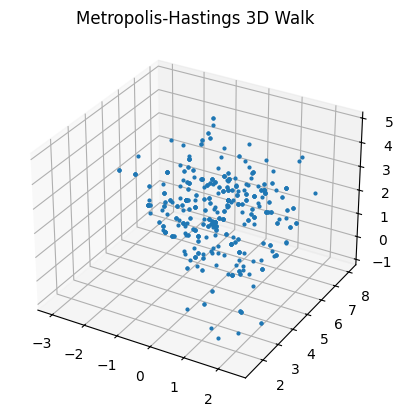

In [13]:
# Шаг 7*. Блуждание в 3D для Метрополиса-Гастингса
from mpl_toolkits.mplot3d import Axes3D

def metropolis_hastings_3d(p, proposal, num_samples, start):
    samples = []
    current = np.array(start)
    for _ in range(num_samples):
        candidate = proposal(current)
        acceptance_ratio = min(1, p(candidate) / p(current))
        if np.random.rand() < acceptance_ratio:
            current = candidate
        samples.append(current)
    return np.array(samples)

# 3D Плотность (Gaussian)
p_3d = lambda x: norm.pdf(x[0], loc=0, scale=1) * norm.pdf(x[1], loc=5, scale=1) * norm.pdf(x[2], loc=2, scale=1)
proposal_3d = lambda x: x + np.random.normal(0, 1, size=3)

samples_3d = metropolis_hastings_3d(p_3d, proposal_3d, 500, [0, 0, 0])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(samples_3d[:, 0], samples_3d[:, 1], samples_3d[:, 2], 'o', markersize=2)
plt.title("Metropolis-Hastings 3D Walk")
plt.show()


In [14]:
# Шаг 8*. Сравнение наборов точек через KL-дивергенцию
from scipy.stats import entropy

hist_original, bins_original = np.histogram(data, bins=30, density=True)
hist_mh, _ = np.histogram(samples_mh, bins=bins_original, density=True)
hist_gibbs, _ = np.histogram(samples_gibbs, bins=bins_original, density=True)

kl_div_mh = entropy(hist_original + 1e-9, hist_mh + 1e-9)
kl_div_gibbs = entropy(hist_original + 1e-9, hist_gibbs + 1e-9)

print(f"KL Divergence (Metropolis-Hastings): {kl_div_mh}")
print(f"KL Divergence (Gibbs): {kl_div_gibbs}")

KL Divergence (Metropolis-Hastings): 0.09295812330650653
KL Divergence (Gibbs): 0.49435570852027205
